# ROMY - Barometric Models

In [57]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np

from src.baroseis import baroseis

### Configurations

In [44]:
# date = "20240312"
# date = "20240315"
# date = "20240324"
date = "20240423"
# date = "20240829"


component = "N"

fmin = 5e-4
fmax = 0.01

# select channel A = tilt, J = rotation rate, H = acceleration
cha ="*A*"

# load config
config_fur = baroseis.load_from_yaml(f"./config/config_FFBI_FUR_{date}_file.yaml")
config_romy = baroseis.load_from_yaml(f"./config/config_FFBI_ROMY_{date}_file.yaml")
config_dromy = baroseis.load_from_yaml(f"./config/config_FFBI_DROMY_{date}_file.yaml")


### Load Spatial Pressure Gradients

In [45]:
gradient = obs.read(f"./data/pressure_gradient_{date}.mseed")

gradient = gradient.trim(config_fur['tbeg'], config_fur['tend'])
gradient = gradient.detrend("demean")
gradient = gradient.taper(0.05, "cosine")
gradient

2 Trace(s) in Stream:
BW.PROMY.01.LDN | 2024-04-23T02:00:00.000000Z - 2024-04-23T05:00:00.000000Z | 1.0 Hz, 10801 samples
BW.PROMY.01.LDE | 2024-04-23T02:00:00.000000Z - 2024-04-23T05:00:00.000000Z | 1.0 Hz, 10801 samples

In [46]:
# Initialize baroseis object
bs_fur = baroseis(conf=config_fur)
bs_romy = baroseis(conf=config_romy)
bs_dromy = baroseis(conf=config_dromy)

# Load data specified in config
bs_fur.load_data()
bs_romy.load_data()
bs_dromy.load_data()

Creating new Hilbert transform data...
 -> No resampling required!

>Runtime: 0.0 minutes

Creating new Hilbert transform data...
 -> No resampling required!

>Runtime: 0.0 minutes

Creating new Hilbert transform data...
 -> No resampling required!

>Runtime: 0.0 minutes



In [47]:

st = obs.Stream()

st.append(bs_fur.st.select(channel="*DO")[0])
st.append(bs_fur.st.select(channel="*DH")[0])

st.append(bs_fur.st.select(component=component)[0])
st.append(bs_romy.st.select(component=component)[0])
st.append(bs_dromy.st.select(component=component)[0])

# st.plot(equal_scale=False);


5 Trace(s) in Stream:
BW.FFBI..BDO   | 2024-04-23T01:00:00.005000Z - 2024-04-23T05:59:59.005000Z | 1.0 Hz, 18000 samples
BW.FFBI..BDH   | 2024-04-23T01:00:00.005000Z - 2024-04-23T05:59:59.005000Z | 1.0 Hz, 18000 samples
GR.FUR..HHN    | 2024-04-23T01:00:00.005000Z - 2024-04-23T05:59:59.005000Z | 1.0 Hz, 18000 samples
BW.ROMY.40.BJN | 2024-04-23T01:00:00.001999Z - 2024-04-23T06:00:00.001999Z | 1.0 Hz, 18001 samples
BW.DROMY..HHN  | 2024-04-23T01:00:00.000000Z - 2024-04-23T06:00:00.000000Z | 1.0 Hz, 18001 samples

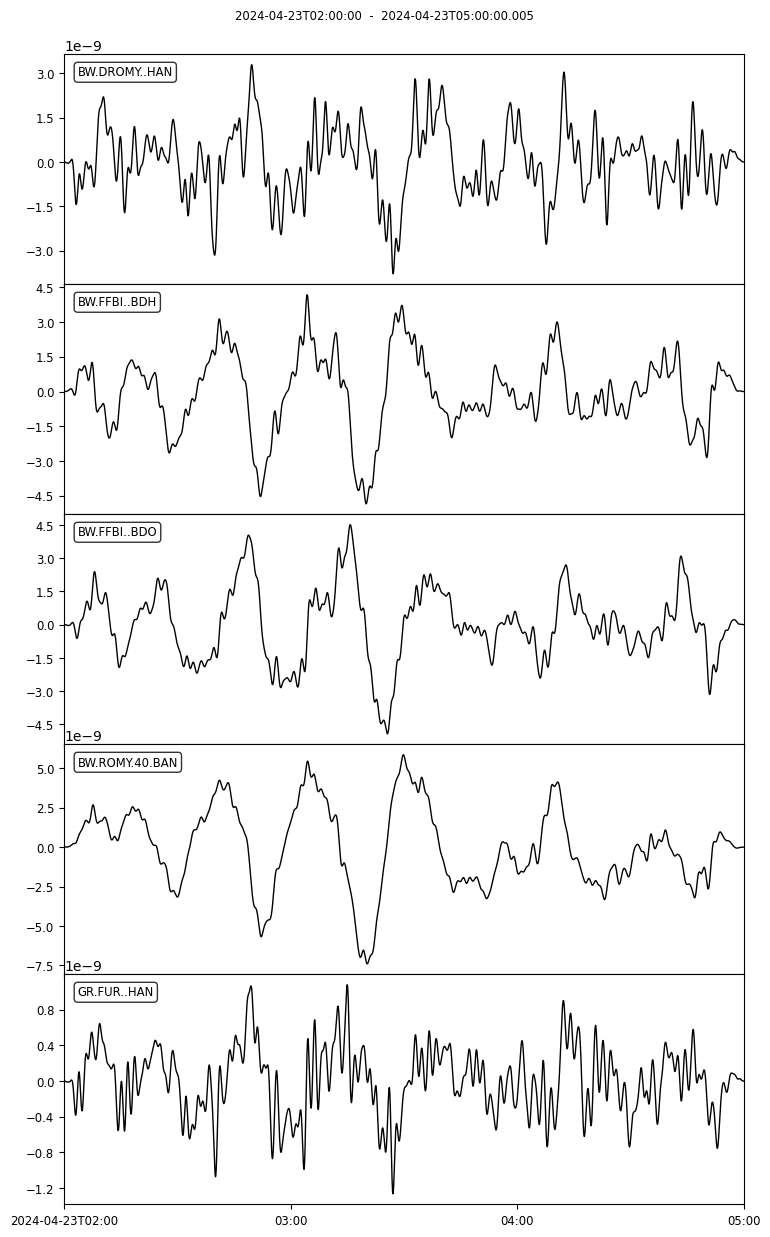

In [48]:
# band pass filer
st.detrend("demean")
st.detrend("linear")
st.taper(0.05, "cosine")
st.filter('bandpass', freqmin=fmin, freqmax=fmax, zerophase=True, corners=4)

# detrend
st.detrend("demean")

# taper edges
st.taper(0.1, "cosine")

for tr in st:
    if tr.stats.station == "ROMY":
        # integrate rotation to tilt
        tr.integrate(method="cumtrapz") # method = "cumtrapz" or "spline"
        tr.stats.channel = tr.stats.channel[0] + "A" + tr.stats.channel[-1]

    elif tr.stats.station == "FUR" or tr.stats.station == "DROMY":
        # convert acceleration to tilt
        tr.stats.channel = tr.stats.channel[0] + "A" + tr.stats.channel[-1]
        if tr.stats.channel[-1] in ["N", "E"]:
            tr.data = -tr.data/9.81

# trim waveforms
st = st.trim(config_fur['tbeg'], config_fur['tend'])

# detrend waveforms
st.detrend("demean")

# taper edges
st.taper(0.05, "cosine")

# show new waveforms
st.plot(equal_scale=False);


In [49]:
def model_tilt(seis_stream, pressure_data):
    """
    Simple model for predicting tilt/rotation from pressure data.
    
    Args:
        seis_stream: Stream with seismic data
        pressure_data: List of pressure arrays [P, H, DP, DH]
    
    Returns:
        Dictionary with predicted_data, coefficients, variance_reduction, residuals
    """
    
    # Get seismic data
    seis_data = {}
    stations = []
    for tr in seis_stream:
        stations.append(tr.stats.station)

    for sta in stations:
        try:
            tr = seis_stream.select(station=sta).copy()[0]
            seis_data[sta] = tr.data
        except:
            continue
    
    if not seis_data:
        raise ValueError("No seismic data found")
    
    # Ensure all data has same length
    data_length = len(pressure_data[0])
    for comp in seis_data:
        if len(seis_data[comp]) != data_length:
            # Simple interpolation
            from scipy.interpolate import interp1d
            x_old = np.linspace(0, 1, len(seis_data[comp]))
            x_new = np.linspace(0, 1, data_length)
            f = interp1d(x_old, seis_data[comp], kind='linear', fill_value='extrapolate')
            seis_data[comp] = f(x_new)
    
    # Create design matrix
    A = np.column_stack(pressure_data)
    
    # Results
    results = {
        'original_data': {},
        'predicted_data': {},
        'coefficients': {},
        'variance_reduction': {},
        'residuals': {}
    }
    
    # Process each component
    for comp, seis_comp_data in seis_data.items():
        # Least squares: A * x = b
        coefficients = np.linalg.lstsq(A, seis_comp_data, rcond=None)[0]
        predicted_data = A @ coefficients
        
        # Variance reduction
        original_var = np.var(seis_comp_data)
        residual_var = np.var(seis_comp_data - predicted_data)
        var_reduction = ((original_var - residual_var) / original_var) * 100
        
        # Store
        results['original_data'][comp] = seis_comp_data
        results['predicted_data'][comp] = predicted_data
        results['coefficients'][comp] = coefficients
        results['variance_reduction'][comp] = var_reduction
        results['residuals'][comp] = seis_comp_data - predicted_data
    
    return results

### Model 1

In [50]:
seis_stream = st.select(channel=cha).copy()
model_data = [
    st.select(channel="*DO").copy()[0].data,
    st.select(channel="*DH").copy()[0].data,
]

# Run model
model1 = model_tilt(seis_stream, model_data)

# Access results
print("Variance reduction:")
for comp in model1['predicted_data']:
    print(f"{comp}: {model1['variance_reduction'][comp]:.1f}%")


Variance reduction:
FUR: 54.7%
ROMY: 80.0%
DROMY: 40.8%


### Model 2

In [51]:
seis_stream = st.select(channel=cha).copy()
pressure_data = [
    st.select(channel="*DO").copy()[0].data,
    st.select(channel="*DH").copy()[0].data,
    st.select(channel="*DO").copy().differentiate()[0].data,
    st.select(channel="*DH").copy().differentiate()[0].data
]

# Run model
model2 = model_tilt(seis_stream, pressure_data)

# Access results
print("Variance reduction:")
for comp in model2['predicted_data']:
    print(f"{comp}: {model2['variance_reduction'][comp]:.1f}%")


Variance reduction:
FUR: 59.0%
ROMY: 83.6%
DROMY: 43.5%


### Model 3

In [52]:
def model_multiple_stations(seis_streams, pressure_streams, coeff_files, station_names, component):
    """
    Model multiple stations using their respective coefficient files.
    Output structure: {'original_data': {'station': array}, 'predicted_data': {'station': array}, ...}
    """
    import yaml
    import numpy as np
    
    comp = component

    # Initialize results with stations as second-level keys
    results = {
        'original_data': {},
        'predicted_data': {},
        'coefficients': {},
        'variance_reduction': {},
        'residuals': {}
    }
    
    for seis_stream, pressure_stream, coeff_file, station_name in zip(
        seis_streams, pressure_streams, coeff_files, station_names):
        
        # Load coefficients
        with open(coeff_file, 'r') as f:
            coeffs = yaml.safe_load(f)
        
        # Get pressure data
        pressure_data = {}
        for tr in pressure_stream:
            if tr.stats.channel.endswith('DH'):
                pressure_data['H'] = tr.data
            elif tr.stats.channel.endswith('DO'):
                pressure_data['P'] = tr.data
        
        # Process each component and combine results
        station_original = []
        station_predicted = []
        station_coeffs = []
        station_residuals = []
        
        try:
            # Get seismic data
            tr = seis_stream.select(channel=f"*{comp}").copy()[0]
            original_data = tr.data
            
            # Get coefficients
            comp_coeffs = coeffs[comp]
            coeff_H = comp_coeffs.get('coeff_H', 0) * 1e-11 # turn from nrad/hPa to rad/Pa
            coeff_P = comp_coeffs.get('coeff_P', 0) * 1e-11 # turn from nrad/hPa to rad/Pa
            
            # Model prediction
            predicted_data = (coeff_H * np.array(pressure_data['H']) + 
                            coeff_P * np.array(pressure_data['P']))

        except Exception as e:
            print(f"Error processing {station_name} {comp}: {e}")
            continue

        results['original_data'][station_name] = original_data
        results['predicted_data'][station_name] = predicted_data
        results['coefficients'][station_name] = [coeff_P, coeff_H]
        results['residuals'][station_name] = original_data - predicted_data
        
        # Calculate variance reduction for the combined station data
        var_orig = np.var(results['original_data'][station_name])
        var_residual = np.var(results['residuals'][station_name])
        var_reduction = ((var_orig - var_residual) / var_orig) * 100
        results['variance_reduction'][station_name] = var_reduction
    
    return results

In [53]:
pressure_stream = obs.Stream()
pressure_stream.append(st.select(channel="*DO").copy()[0])
pressure_stream.append(st.select(channel="*DH").copy()[0])

seis_stream_dromy = st.select(station="DROMY").copy()
seis_stream_romy = st.select(station="ROMY").copy()
seis_stream_fur = st.select(station="FUR").copy()


model3 = model_multiple_stations(
    [seis_stream_dromy, seis_stream_romy, seis_stream_fur],
    [pressure_stream, pressure_stream, pressure_stream], 
    ['data/statsmodel_DROMY.yaml', 'data/statsmodel_ROMY_v2.yaml', 'data/statsmodel_FUR.yaml'],
    ['DROMY', 'ROMY', 'FUR'],
    component
)

In [54]:
models = {
    'Adaptive Model': model1,
    'Statistic Model': model3
}

In [55]:
def plot_waveform_comparison(model_results,
                           time_unit='minutes', residual=False, figsize=(15, 10)):
    """
    Simple plot with vertical subplots showing waveforms for each station.
    
    Args:
        model_results: Dictionary with model names as keys and results as values.
                      Each result should contain 'original_data' and 'predicted_data' for each station.
        time_unit: Time unit for x-axis
        residual: Boolean to plot residuals
        figsize: Figure size
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Get time scaling
    tscale_dict = {"hours": 1/3600, "days": 1/86400, "minutes": 1/60, "seconds": 1}
    tscale = tscale_dict.get(time_unit, 1/60)
    
    # Get the first model to determine units and scaling
    first_model = list(model_results.values())[0]
    first_station = list(first_model['original_data'].keys())[0]
    
    # Set units and scaling based on the data
    # You might need to adjust this based on your data structure
    ylabel = "Tilt (nrad)"
    yscale = 1e9  # Adjust based on your data units
    
    # Get unique stations from the first model's data
    stations = list(first_model['original_data'].keys())
    stations.sort()  # Sort for consistent ordering
    
    font = 14

    # Create subplots for each station
    fig, axes = plt.subplots(len(stations), 1, figsize=figsize, sharex=True)
    
    # Handle case where there's only one station
    if len(stations) == 1:
        axes = [axes]
    
    # Colors for different models
    colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
    
    # Plot each station
    for i, station in enumerate(stations):
        try:
            # Get original data for this station from the first model
            orig_data = first_model['original_data'][station] * yscale
            
            # Create time array (assuming uniform sampling)
            # You might need to adjust this based on your data structure
            n_samples = len(orig_data)
            dt = 1.0  # Adjust this based on your sampling rate
            times = np.arange(n_samples) * dt * tscale
            
            # Plot original data
            axes[i].plot(times, orig_data, 'k-', linewidth=2.5, 
                        label=f'{station}-{component}', alpha=1, zorder=1)
            max_orig = np.max(np.abs(orig_data))

            # Plot each model for this station
            for j, (model_name, results) in enumerate(model_results.items()):
                if station in results.get('predicted_data', {}):
                    pred_data = results['predicted_data'][station] * yscale
                    var_reduction = results.get('variance_reduction', {}).get(station, 0)
                    
                    color = colors[j % len(colors)]
                    if residual:
                        res_data = orig_data - pred_data
                        axes[i].plot(times, res_data, color=color, linewidth=2, zorder=2,
                                label=f'{model_name} (VR: {var_reduction:.1f}%)', alpha=0.9)
                        # find y absolute maximum for ylim
                        y_max = np.max([np.max(np.abs(res_data)), max_orig])*1.01
                        axes[i].set_ylim(-y_max, y_max)
                    else:
                        axes[i].plot(times, pred_data, color=color, linewidth=2, zorder=2,
                                label=f'{model_name} (VR: {var_reduction:.1f}%)', alpha=0.9)
                        # find y absolute maximum for ylim
                        y_max = np.max([np.max(np.abs(pred_data)), max_orig])*1.01
                        axes[i].set_ylim(-y_max, y_max)
            
            # Format subplot
            axes[i].set_ylabel(f"{ylabel}", fontsize=font)
            axes[i].set_title(f"Station {station}", fontsize=font, fontweight='bold')
            axes[i].legend(fontsize=font-2, ncol=3, loc="lower right")
            axes[i].grid(True, alpha=0.3)
            axes[i].tick_params(labelsize=font-1)
    
        except Exception as e:
            print(f"Error plotting station {station}: {e}")
            axes[i].text(0.5, 0.5, f'Error loading station {station}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            continue
    
    # Set x-axis label
    axes[-1].set_xlabel(f"Time ({time_unit})", fontsize=font)
    
    # Set overall title
    # if residual:
    #     title = f"Residual Comparison - Stations"
    # else:
    #     title = f"Model Comparison - Stations"
    # fig.suptitle(title, fontsize=font+2, fontweight='bold')
    
    # # Add model names as text outside the frame
    # model_names = list(model_results.keys())
    # model_text = "Models:  " + ",   ".join([f"{name}" for i, name in enumerate(model_names)])
    
    # # Add text below the plot
    # fig.text(0.5, 0.02, model_text, ha='center', va='bottom', fontsize=font-2, 
    #          bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    # Adjust layout to make room for the model text
    plt.subplots_adjust(bottom=0.1)
    return fig

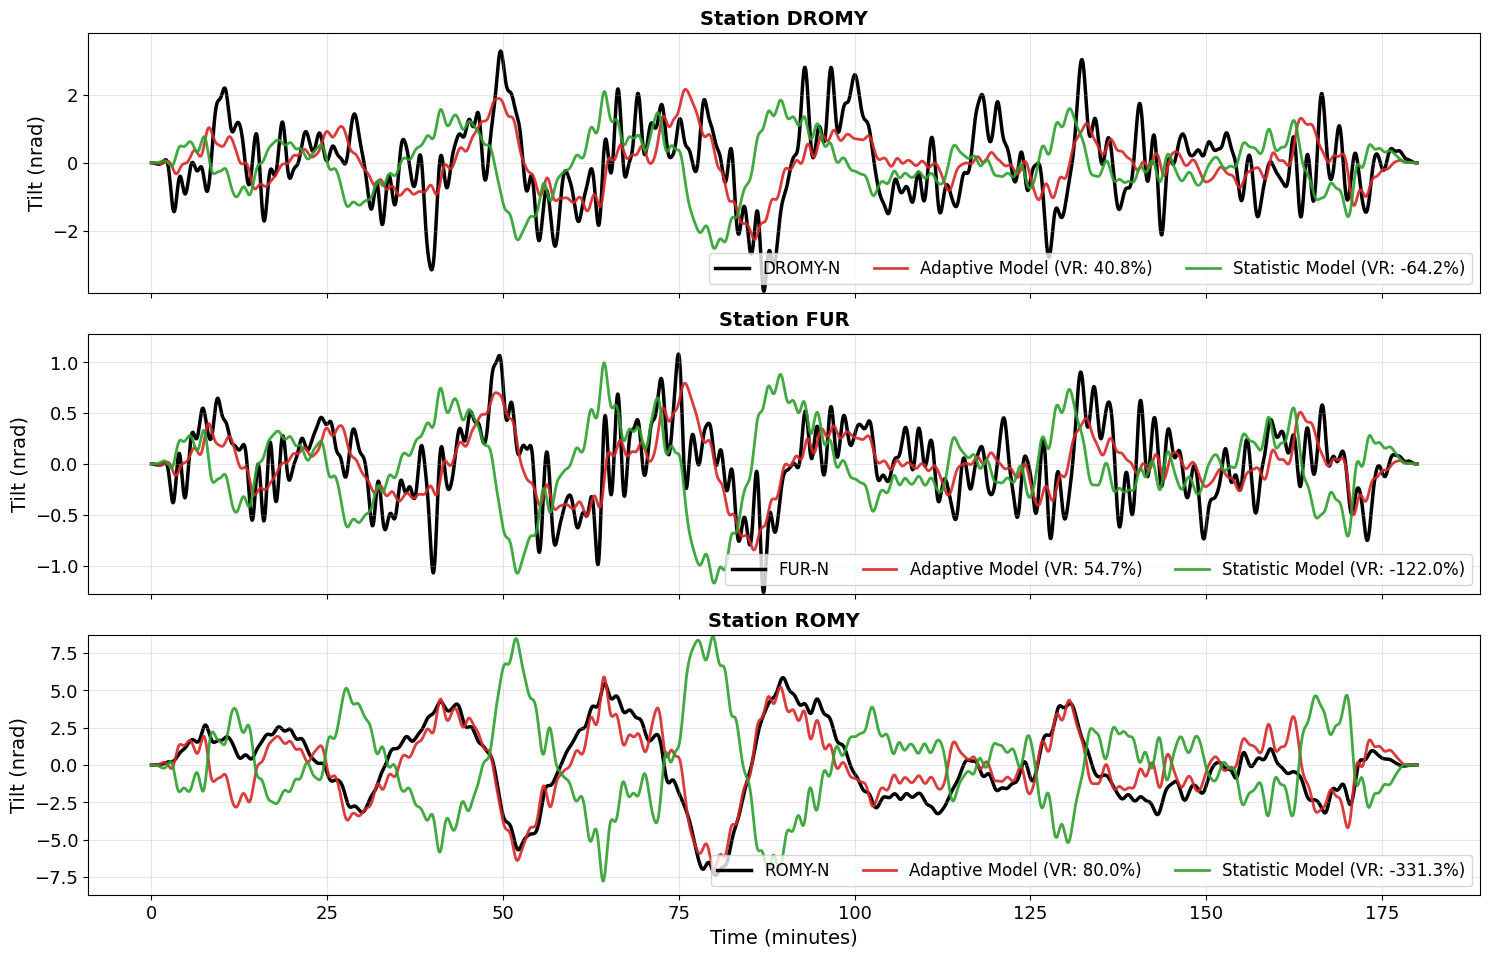

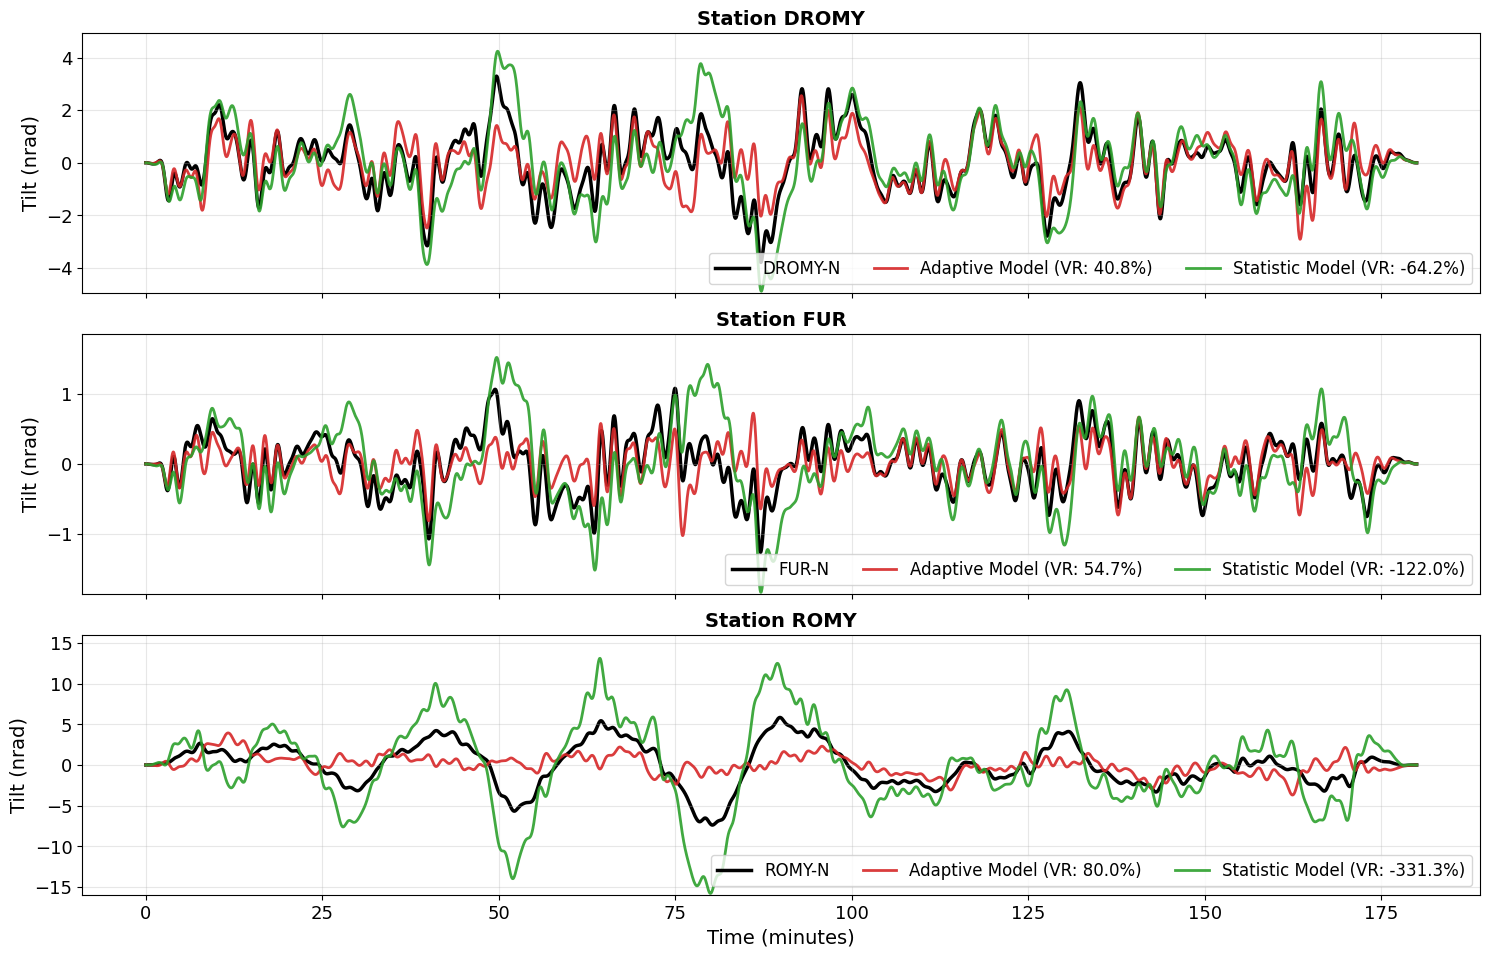

In [56]:
fig = plot_waveform_comparison(models, residual=False)

fig.savefig(f"./figures/station_comparison/{date}_{component}_station_waveform_comparison.png", dpi=150, bbox_inches="tight")

fig = plot_waveform_comparison(models, residual=True)

fig.savefig(f"./figures/station_comparison/{date}_{component}_station_waveform_comparison_residual.png", dpi=150, bbox_inches="tight")


### Create Output Table

In [16]:
def results_table(model_results, date, station_names, components, filename):
    """
    Save model results to CSV file, updating existing data if file exists.
    
    Args:
        model_results: Dictionary with model results
        date: Date string
        station_names: List of station names
        components: List of components
        filename: CSV file path to save to
    """
    import pandas as pd
    import os
    
    # Read existing data if file exists
    if os.path.exists(filename):
        existing_df = pd.read_csv(filename)
    else:
        existing_df = pd.DataFrame()
    
    # Create new data
    rows = []
    models = model_results if isinstance(model_results, dict) and 'variance_reduction' not in model_results else {'model1': model_results}
    
    for model_name, results in models.items():
        for station in station_names:
            for comp in components:
                vr = results.get('variance_reduction', {}).get(station, 0)
                rows.append({
                    'Date': date,
                    'Station': station,
                    'Component': comp,
                    'Model': model_name,
                    'Variance_Reduction': vr
                })
    
    new_df = pd.DataFrame(rows)
    
    # Remove old entries for same date/station/component/model
    if not existing_df.empty:
        mask = ~((existing_df['Date'] == date) & 
                (existing_df['Station'].isin(station_names)) & 
                (existing_df['Component'].isin(components)) & 
                (existing_df['Model'].isin(models.keys())))
        existing_df = existing_df[mask]
        combined_df = pd.concat([existing_df, new_df], ignore_index=True)
    else:
        combined_df = new_df
    
    # remove identical rows
    combined_df = combined_df.drop_duplicates()

    # sorting
    combined_df = combined_df.sort_values(by=['Date', 'Station', 'Component', 'Model'])

    # Save to file
    combined_df.to_csv(filename, index=False)
    print(f"Saved {len(combined_df)} rows to {filename}")
    
    return combined_df

In [17]:

station_names = ['ROMY', 'FUR', 'DROMY']

# Create table
results_table = results_table(models, date, station_names, [component], "./data/model_stations_vr_results.csv")
print(results_table)



Saved 42 rows to ./data/model_stations_vr_results.csv
        Date Station Component            Model  Variance_Reduction
0   20240315   DROMY         E   Adaptive Model           64.501771
1   20240315   DROMY         E  Statistic Model           63.990977
2   20240315   DROMY         N   Adaptive Model           12.147146
3   20240315   DROMY         N   Adaptive Model           16.497524
4   20240315   DROMY         N  Statistic Model           -0.099776
5   20240315   DROMY         N  Statistic Model          -30.620557
6   20240315     FUR         E   Adaptive Model           30.827652
7   20240315     FUR         E  Statistic Model         -120.975325
8   20240315     FUR         N   Adaptive Model           45.919098
9   20240315     FUR         N   Adaptive Model           57.273120
10  20240315     FUR         N  Statistic Model           45.460772
11  20240315     FUR         N  Statistic Model          -70.981986
12  20240315    ROMY         E   Adaptive Model           96.9

In [ ]:
def save_latex_table(df, filename, caption="Model Results"):
    """
    Convert DataFrame to LaTeX table and save to file.
    
    Args:
        df: pandas DataFrame
        filename: Output .tex file path
        caption: Table caption
    """
    import pandas as pd
    
    # Format variance reduction to 1 decimal place
    df_formatted = df.copy()
    if 'Variance_Reduction' in df_formatted.columns:
        df_formatted['Variance_Reduction'] = df_formatted['Variance_Reduction'].round(1)
    
    # Generate LaTeX table
    latex_code = df_formatted.to_latex(
        index=False,
        escape=False,
        caption=caption,
        label="tab:results",
        position='htbp'
    )
    
    # Save to file
    with open(filename, 'w') as f:
        f.write(latex_code)
    
    print(f"LaTeX table saved to {filename}")
    return latex_code

In [ ]:
def save_latex_table(df, filename, caption="Model Results"):
    """
    Convert DataFrame to LaTeX table with multirow support for combined cells.
    """
    import pandas as pd
    
    # Format and sort DataFrame
    df_formatted = df.copy()
    if 'Variance_Reduction' in df_formatted.columns:
        df_formatted['Variance_Reduction'] = df_formatted['Variance_Reduction'].round(1)
    
    df_sorted = df_formatted.sort_values(['Date', 'Station', 'Component'])
    
    # Count occurrences for multirow
    date_counts = df_sorted.groupby('Date').size()
    station_counts = df_sorted.groupby(['Date', 'Station']).size()
    component_counts = df_sorted.groupby(['Date', 'Station', 'Component']).size()
    
    latex_lines = []
    latex_lines.append("\\begin{table}[htbp]")
    latex_lines.append("\\centering")
    latex_lines.append(f"\\caption{{{caption}}}")
    latex_lines.append("\\label{tab:results}")
    latex_lines.append("\\begin{tabular}{lcccc}")
    latex_lines.append("\\toprule")
    latex_lines.append("Date & Station & Component & Model & Variance Reduction \\\\")
    latex_lines.append("\\midrule")
    
    # Track previous values
    prev_date = None
    prev_station = None
    prev_component = None
    
    for _, row in df_sorted.iterrows():
        current_date = row['Date']
        current_station = row['Station']
        current_component = row['Component']
        model = row['Model']
        vr = row['Variance_Reduction']
        
        # Determine what to show
        if current_date != prev_date:
            date_col = f"\\multirow{{{date_counts[current_date]}}}{{*}}{{{current_date}}}"
        else:
            date_col = ""
            
        if current_station != prev_station or current_date != prev_date:
            station_col = f"\\multirow{{{station_counts[(current_date, current_station)]}}}{{*}}{{{current_station}}}"
        else:
            station_col = ""
            
        if current_component != prev_component or current_station != prev_station or current_date != prev_date:
            component_col = f"\\multirow{{{component_counts[(current_date, current_station, current_component)]}}}{{*}}{{{current_component}}}"
        else:
            component_col = ""
        
        # Add row
        latex_lines.append(f"{date_col} & {station_col} & {component_col} & {model} & {vr} \\\\")
        
        # Update previous values
        prev_date = current_date
        prev_station = current_station
        prev_component = current_component
    
    latex_lines.append("\\bottomrule")
    latex_lines.append("\\end{tabular}")
    latex_lines.append("\\end{table}")
    
    latex_code = "\n".join(latex_lines)
    
    with open(filename, 'w') as f:
        f.write(latex_code)
    
    print(f"LaTeX table with multirow saved to {filename}")
    return latex_code

In [ ]:
save_latex_table(results_table, './data/results.tex', "Model Variance Reduction Results")


LaTeX table with multirow saved to ./data/results.tex


'\\begin{table}[htbp]\n\\centering\n\\caption{Model Variance Reduction Results}\n\\label{tab:results}\n\\begin{tabular}{lcccc}\n\\toprule\nDate & Station & Component & Model & Variance Reduction \\\\\n\\midrule\n\\multirow{18}{*}{20240315} & \\multirow{6}{*}{DROMY} & \\multirow{2}{*}{E} & Adaptive Model & 64.5 \\\\\n &  &  & Statistic Model & 64.0 \\\\\n &  & \\multirow{4}{*}{N} & Adaptive Model & 12.1 \\\\\n &  &  & Adaptive Model & 16.5 \\\\\n &  &  & Statistic Model & -0.1 \\\\\n &  &  & Statistic Model & -30.6 \\\\\n & \\multirow{6}{*}{FUR} & \\multirow{2}{*}{E} & Adaptive Model & 30.8 \\\\\n &  &  & Statistic Model & -121.0 \\\\\n &  & \\multirow{4}{*}{N} & Adaptive Model & 45.9 \\\\\n &  &  & Adaptive Model & 57.3 \\\\\n &  &  & Statistic Model & 45.5 \\\\\n &  &  & Statistic Model & -71.0 \\\\\n & \\multirow{6}{*}{ROMY} & \\multirow{2}{*}{E} & Adaptive Model & 96.9 \\\\\n &  &  & Statistic Model & 54.8 \\\\\n &  & \\multirow{4}{*}{N} & Adaptive Model & 96.6 \\\\\n &  &  & Adapti

In [ ]:
def plot_spectra_comparison(seis_stream, model_results,
                           method='welch', fmin=0.0005, fmax=0.03,
                           log_scale=True, db_scale=False, residual=False, 
                           smooth_octave=False, octave_fraction=1/3, 
                           smooth_method='median', figsize=(15, 10)):
    """
    Plot spectra comparison for 3 components (Z, N, E) showing spectra for each model.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.signal import welch
    from scipy.fft import fft, fftfreq
    from scipy.signal import windows

    def smooth_octave_bands(freq, spectrum, octave_fraction=1/3, method='median'):
        """Smooth spectrum in fractional octave bands."""
        # Create octave band centers
        f_min = freq[freq > 0].min()
        f_max = freq.max()
        
        # Calculate number of octave bands
        n_octaves = int(np.log2(f_max / f_min) / octave_fraction) + 1
        
        # Create octave band centers
        f_centers = f_min * (2 ** (octave_fraction * np.arange(n_octaves)))
        
        # Calculate band edges
        f_lower = f_centers / (2 ** (octave_fraction / 2))
        f_upper = f_centers * (2 ** (octave_fraction / 2))
        
        # Initialize smoothed arrays
        freq_smooth = []
        spectrum_smooth = []
        
        for i in range(len(f_centers)):
            # Find frequencies within this octave band
            mask = (freq >= f_lower[i]) & (freq <= f_upper[i])
            
            if np.any(mask):
                if method == 'median':
                    smooth_val = np.median(spectrum[mask])
                else:  # mean
                    smooth_val = np.mean(spectrum[mask])
                
                freq_smooth.append(f_centers[i])
                spectrum_smooth.append(smooth_val)
        
        return np.array(freq_smooth), np.array(spectrum_smooth)

    # Set units and scaling
    channel_type = seis_stream[0].stats.channel[1]
    if channel_type == 'J':
        ylabel = "Rotation Rate\n(nrad/s)"
        yscale = 1e9
    elif channel_type == 'A':
        ylabel = "Tilt (nrad)"
        yscale = 1e9
    elif channel_type == 'H':
        ylabel = "Acceleration\n(nm/s²)"
        yscale = 1e9
    else:
        ylabel = "Amplitude"
        yscale = 1.0

    components = ['Z', 'N', 'E']
    font = 14

    # Create 3 vertical subplots
    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)
    
    # Colors for different models
    colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
    
    # Plot each component
    for i, comp in enumerate(components):
        try:
            # Get original data
            orig_tr = seis_stream.select(channel=f"*{comp}").copy()[0]
            
            # Compute original spectrum
            if method.lower() == 'fft':
                n = len(orig_tr.data)
                win = windows.hann(n)
                spec_orig = fft(orig_tr.data * win)
                freq = fftfreq(n, d=orig_tr.stats.delta)
                pos_freq = freq[0:n//2]
                mag_orig = np.abs(spec_orig[0:n//2]) * 2.0/n * yscale
            else:  # welch
                nperseg = int(orig_tr.stats.sampling_rate * 3600)  # 1-hour segments
                noverlap = nperseg // 2
                freq, psd_orig = welch(orig_tr.data, fs=orig_tr.stats.sampling_rate,
                                     window='hann', nperseg=nperseg, noverlap=noverlap)
                mag_orig = np.sqrt(psd_orig) * yscale
                pos_freq = freq
            
            # Apply octave band smoothing if requested
            if smooth_octave:
                pos_freq, mag_orig = smooth_octave_bands(pos_freq, mag_orig, 
                                                        octave_fraction, smooth_method)
            
            # Convert to dB if requested
            if db_scale:
                mag_orig = 20 * np.log10(mag_orig)
                ylabel_comp = ylabel + " (dB)"
            else:
                ylabel_comp = ylabel
            
            # Apply frequency limits
            mask = (pos_freq >= fmin) & (pos_freq <= fmax)
            pos_freq_plot = pos_freq[mask]
            mag_orig_plot = mag_orig[mask]
            
            # Plot original spectrum
            axes[i].plot(pos_freq_plot, mag_orig_plot, 'k-', linewidth=2, 
                        label=f'{comp}-Component', alpha=1, zorder=1)

            # Plot each model
            for j, (model_name, results) in enumerate(model_results.items()):
                if comp in results['predicted_data']:
                    residual_tr = seis_stream.select(channel=f"*{comp}").copy()[0]
                    residual_tr.data = seis_stream.select(channel=f"*{comp}").copy()[0].data - results['predicted_data'][comp]
                    var_reduction = results['variance_reduction'][comp]
                    
                    # Compute predicted spectrum
                    if method.lower() == 'fft':
                        n = len(residual_tr.data)
                        win = windows.hann(n)
                        spec_pred = fft(residual_tr.data * win)
                        mag_pred = np.abs(spec_pred[0:n//2]) * 2.0/n * yscale
                        freq_pred = fftfreq(n, d=residual_tr.stats.delta)[0:n//2]
                    else:  # welch
                        nperseg = int(residual_tr.stats.sampling_rate * 3600)
                        noverlap = nperseg // 2
                        freq_pred, psd_pred = welch(residual_tr.data, fs=residual_tr.stats.sampling_rate,
                                                  window='hann', nperseg=nperseg, noverlap=noverlap)
                        mag_pred = np.sqrt(psd_pred) * yscale
                    
                    # Apply octave band smoothing if requested
                    if smooth_octave:
                        freq_pred, mag_pred = smooth_octave_bands(freq_pred, mag_pred, 
                                                                octave_fraction, smooth_method)
                    
                    # Convert to dB if requested
                    if db_scale:
                        mag_pred = 20 * np.log10(mag_pred)
                    
                    # Apply frequency limits
                    mask_pred = (freq_pred >= fmin) & (freq_pred <= fmax)
                    pos_freq_pred_plot = freq_pred[mask_pred]
                    mag_pred_plot = mag_pred[mask_pred]
                    
                    color = colors[j % len(colors)]
                    if residual:
                        # For residuals, we need to interpolate to match frequencies
                        from scipy.interpolate import interp1d
                        f_interp = interp1d(pos_freq_plot, mag_orig_plot, kind='linear', 
                                          bounds_error=False, fill_value=0)
                        mag_orig_interp = f_interp(pos_freq_pred_plot)
                        res_spectrum = mag_orig_interp - mag_pred_plot
                        axes[i].plot(pos_freq_pred_plot, res_spectrum, color=color, linewidth=1.5, zorder=2,
                                label=f'M{j+1} (VR: {var_reduction:.1f}%)', alpha=0.9)
                    else:
                        axes[i].plot(pos_freq_pred_plot, mag_pred_plot, color=color, linewidth=1.5, zorder=2,
                                label=f'M{j+1} (VR: {var_reduction:.1f}%)', alpha=0.9)
            
            # Format subplot
            axes[i].set_ylabel(r"ASD nrad/$\sqrt{Hz}$", fontsize=font)
            axes[i].legend(loc='lower left', fontsize=font-2, ncol=2)
            axes[i].grid(True, alpha=0.3)
            axes[i].tick_params(labelsize=font-1)
            
            # Set scales
            if log_scale:
                axes[i].set_xscale('log')
                if not db_scale:  # Only use log scale for y-axis if not in dB
                    axes[i].set_yscale('log')
    
        except Exception as e:
            print(f"Error plotting {comp}: {e}")
            axes[i].text(0.5, 0.5, f'Error loading {comp}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            continue
    
    # Set x-axis label
    axes[-1].set_xlabel("Frequency (Hz)", fontsize=font)
    
    # Set overall title
    if residual:
        title = f"Spectra Residual Comparison"
    else:
        title = f"Spectra Model Comparison"
    fig.suptitle(title, fontsize=font+2, fontweight='bold')
    
    # Add model names as text outside the frame
    model_names = list(model_results.keys())
    model_text = "Models:  " + ",   ".join([f"{name}" for i, name in enumerate(model_names)])
    
    # Add text below the plot
    fig.text(0.5, 0.02, model_text, ha='center', va='bottom', fontsize=font-2, 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    # Adjust layout to make room for the model text
    plt.subplots_adjust(bottom=0.1)
    return fig

In [ ]:
# fig = plot_spectra_comparison(seis_stream, model_results, method='fft', db_scale=False)

# fig = plot_spectra_comparison(seis_stream, model_results, method='fft',
#                              smooth_octave=True, octave_fraction=1/6, smooth_method='median')

In [ ]:
# fig = plot_spectra_comparison(seis_stream, model_results, 
#                              smooth_octave=True, octave_fraction=1/2, smooth_method='median')
